# Hydroglaciology

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import math
import datetime
import time
import obspy

In [80]:
direct = 'D:\MEMOIRE\HYDRO'
stt_gauging = '\V550\Vdv_data_20221116122909'
stt_temp = '\V159\Vdv_data_20221116124304'

In [81]:
gauging_time = []
gauging_velos = []

with open(direct+stt_gauging+'.csv') as file :
    readcsv = csv.reader(file, delimiter=';')
    line = 0
    for row in readcsv :
        if line > 4 :
            gauging_date = datetime.datetime.strptime(str(row[0]), '%Y-%m-%d %H:%M:%S')
            gauging_time.append(gauging_date)
            gauging_velos.append(float(row[3].replace(',','.')))
            
        line += 1

temp_time = []
temp = []

with open(direct+stt_temp+'.csv') as file :
    readcsv = csv.reader(file, delimiter=';')
    line = 0
    for row in readcsv :
        if line > 4 :
            temp_date = datetime.datetime.strptime(str(row[0]), '%Y-%m-%d %H:%M:%S')
            temp_time.append(temp_date)
            temp.append(float(row[1].replace(',','.')))
            
        line += 1

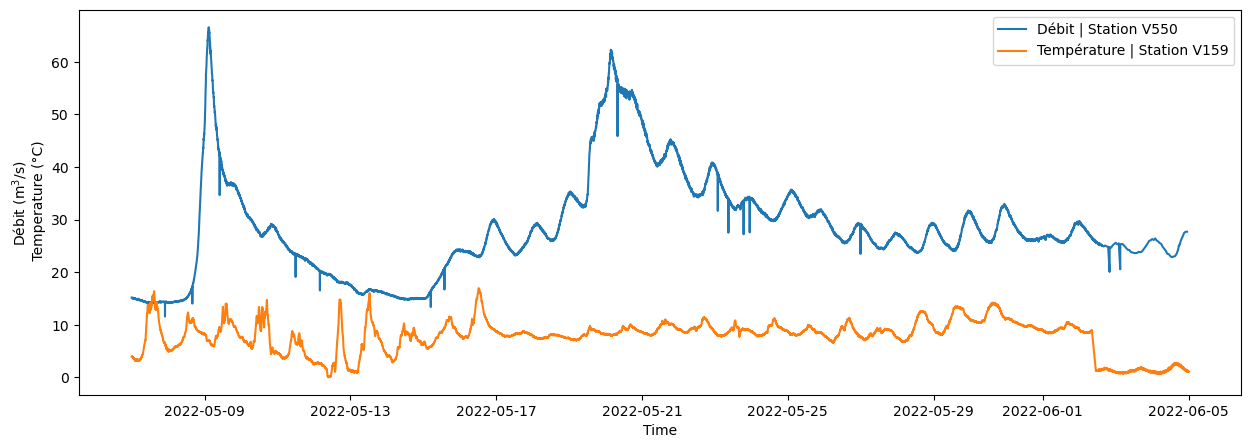

In [82]:
fig = plt.figure(figsize=(15, 5))
plt.plot(gauging_time, gauging_velos, label = 'Débit | Station V550')
plt.plot(temp_time, temp, label = 'Température | Station V159')
plt.xlabel('Time')
plt.ylabel('Débit (m$^3$/s) \n Temperature (°C)')
plt.legend()
plt.show()

### Determining the frequency of the signal
Crédit :
https://stackoverflow.com/questions/27673496/python-numpy-fft-or-rfft-to-find-period-of-a-wave-instead-of-its-frequiency

In [83]:
#sample_rate = 180
temp = np.array(temp)
amp_temp =np.abs(np.fft.rfft(temp, n=temp.size))
freq_temp = np.fft.rfftfreq(temp.size, d=1/456)
amp_temp[0] = 0
idx = amp_temp.argmax()
print(freq_temp[idx])

0.138349514563


In [84]:
#sample_rate = 180
gauging_velos = np.array(gauging_velos)
amp_gauging_velos =np.abs(np.fft.rfft(gauging_velos, n=gauging_velos.size))
freq_gauging_velos = np.fft.rfftfreq(gauging_velos.size, d=1/288)
amp_gauging_velos[0] = 0
idx = amp_gauging_velos.argmax()
print(freq_gauging_velos[idx])

0.0371517027864


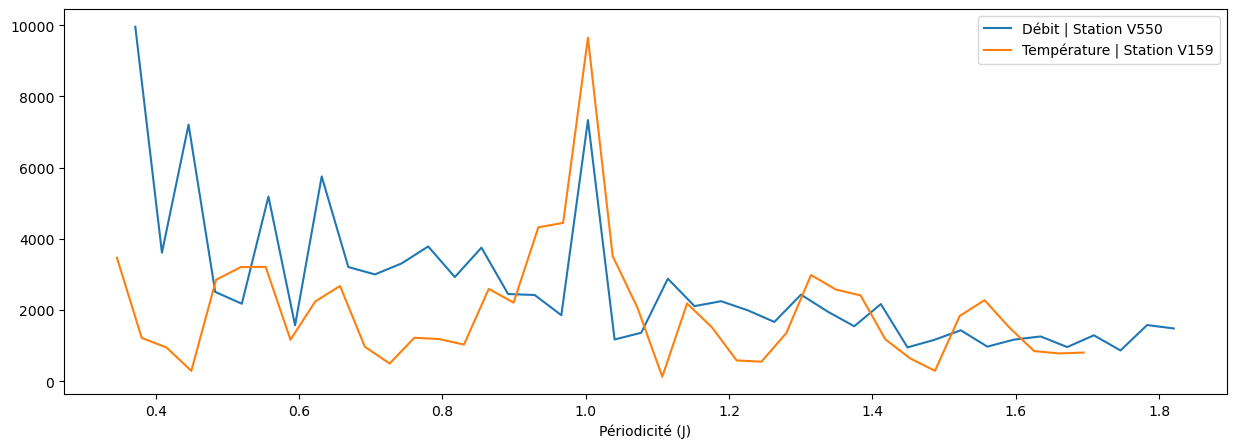

In [85]:
fig = plt.figure(figsize=(15, 5))
plt.plot(freq_gauging_velos[10:50], amp_gauging_velos[10:50], label="Débit | Station V550")
plt.plot(freq_temp[10:50], amp_temp[10:50] , label="Température | Station V159")
plt.xlabel('Périodicité (J)')
plt.legend()
plt.show()


In [86]:
n=1
max_temp = []
max_velos = []
for i in range(len(temp_time)):
    #print(i)
    if temp_time[0] == temp_time[i] - datetime.timedelta(hours=n*24) :
        idx = np.argmax(temp[i-456:i]) + (i-456)
        max_temp.append(temp_time[idx])
        #print(i-456)
        n+= 1
        
n=1        
for i in range(len(gauging_time)):
    #print(i)
    if gauging_time[0] == gauging_time[i] - datetime.timedelta(hours=n*24) :
        idx = np.argmax(gauging_velos[i-289:i]) + (i-289)
        max_velos.append(gauging_time[idx])
        n+= 1
    
delta_time = np.subtract(max_velos, max_temp)

for i in range(len(delta_time)) :
    delta_time[i] = delta_time[i]/datetime.timedelta(hours=1)
    

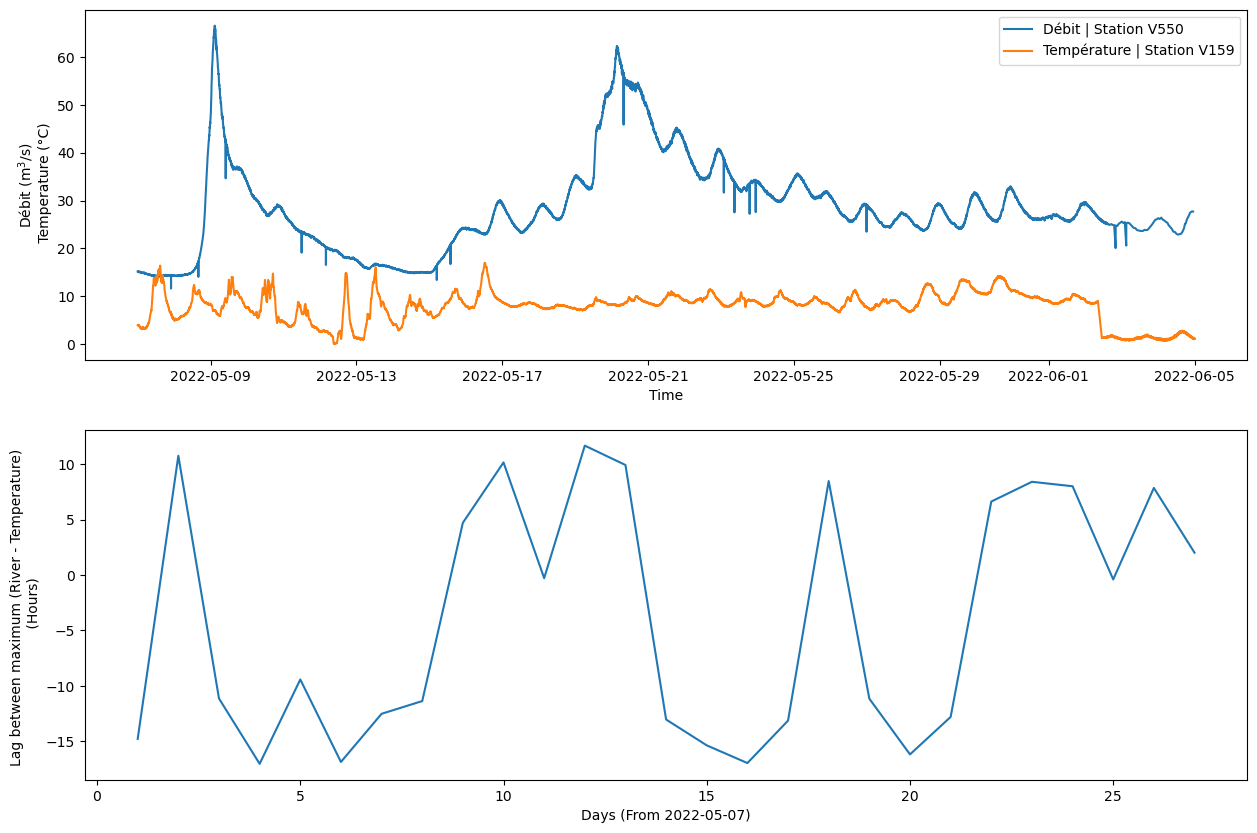

In [87]:
fig = plt.subplots(2, 1, figsize=(15, 10))
plt.subplot(2, 1, 1)


plt.plot(gauging_time, gauging_velos, label = 'Débit | Station V550')
plt.plot(temp_time, temp, label = 'Température | Station V159')
plt.xlabel('Time')
plt.ylabel('Débit (m$^3$/s) \n Temperature (°C)')
plt.legend()


plt.subplot(2, 1, 2)

day = list(range(1,28))
#plt.plot(day,max_temp.date())
#plt.plot(day,max_velos.time())
plt.plot(day, delta_time[:27])
plt.xlabel('Days (From 2022-05-07)')
plt.ylabel('Lag between maximum (River - Temperature) \n (Hours)')
plt.show()

In [88]:
root = "D:\\Nodes_ablation_zone\All_comp_DP_\\"
azimuth = ['N','E','Z']
Traces = []
for coump in azimuth :
    Traces.append(obspy.read(root+'453020739.16.2022.05.21.00.00.00.000.'+str(coump)+'.miniseed'))

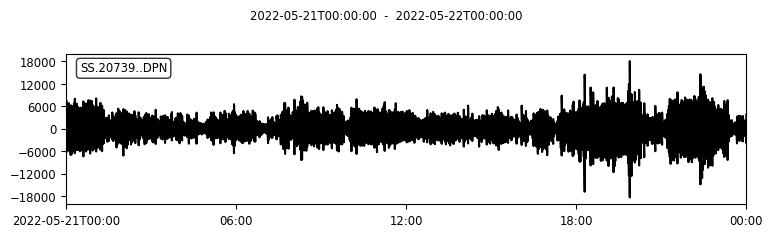

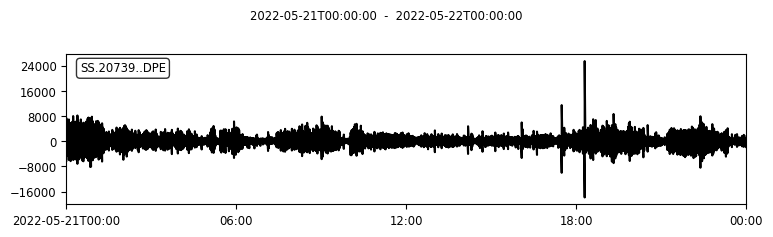

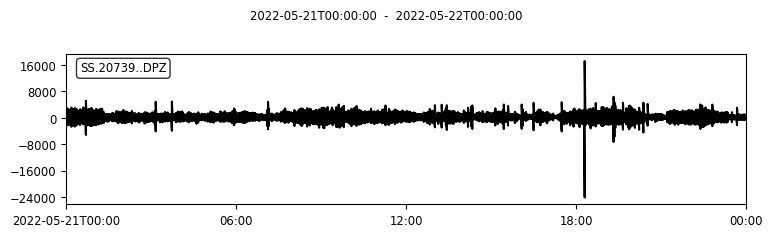

In [89]:
for trace in Traces :
    trace.plot()

In [125]:
root = "D:\\Nodes_ablation_zone\All_comp_DP_\\"


startday = 8
startnumber = 3
days = 26 - startnumber

median = []
mean = []

for day in range(days) :
    start = time.process_time() 
    if startday+day < 10 :
        trace = obspy.read(root+'453020781.'+str(startnumber+day)+'.2022.05.0'+str(startday+day)+'.00.00.00.000.Z.miniseed')
    elif startday+day >= 10 :
        trace = obspy.read(root+'453020781.'+str(startnumber+day)+'.2022.05.'+str(startday+day)+'.00.00.00.000.Z.miniseed')
    if day == 0 :
        starttime = trace[0].stats.starttime
        noise_time = [starttime]
    
    window_size = 10 #minutes
    window = 24*60/window_size

    trace = np.array(trace[0])

    trace = np.abs(trace)


    npts_p_min = int(len(trace)/(24*60))


    for i in range(int(window)) :
        t0 = i*npts_p_min
        t1 = npts_p_min + i*npts_p_min
        array = trace[t0:t1]
        #mode.append(scipy.stats.mode(array))
        mean.append(np.mean(array))
        median.append(np.median(array))
        if i > 0 and day == 0 :
            noise_time.append(noise_time[i-1]+datetime.timedelta(minutes=10))
        elif day > 0 :
            base = int(day*window)
            noise_time.append(noise_time[base+i-1]+datetime.timedelta(minutes=10))
    end = time.process_time() 
    print('Days '+str(day+startnumber)+' accomplished in '+str(end-start)+' seconds')

Days 3 accomplished in 12.34375 seconds
Days 4 accomplished in 20.234375 seconds
Days 5 accomplished in 17.390625 seconds
Days 6 accomplished in 18.03125 seconds
Days 7 accomplished in 16.5625 seconds
Days 8 accomplished in 17.15625 seconds
Days 9 accomplished in 18.046875 seconds
Days 10 accomplished in 15.359375 seconds
Days 11 accomplished in 13.75 seconds
Days 12 accomplished in 13.8125 seconds
Days 13 accomplished in 17.234375 seconds
Days 14 accomplished in 11.640625 seconds
Days 15 accomplished in 18.5625 seconds
Days 16 accomplished in 14.046875 seconds
Days 17 accomplished in 20.25 seconds
Days 18 accomplished in 22.078125 seconds
Days 19 accomplished in 17.9375 seconds
Days 20 accomplished in 15.375 seconds
Days 21 accomplished in 20.03125 seconds
Days 22 accomplished in 18.265625 seconds
Days 23 accomplished in 19.296875 seconds
Days 24 accomplished in 14.578125 seconds
Days 25 accomplished in 18.34375 seconds


In [126]:
print(len(median))
print(len(mean))
print(len(noise_time))

3312
3312
3312


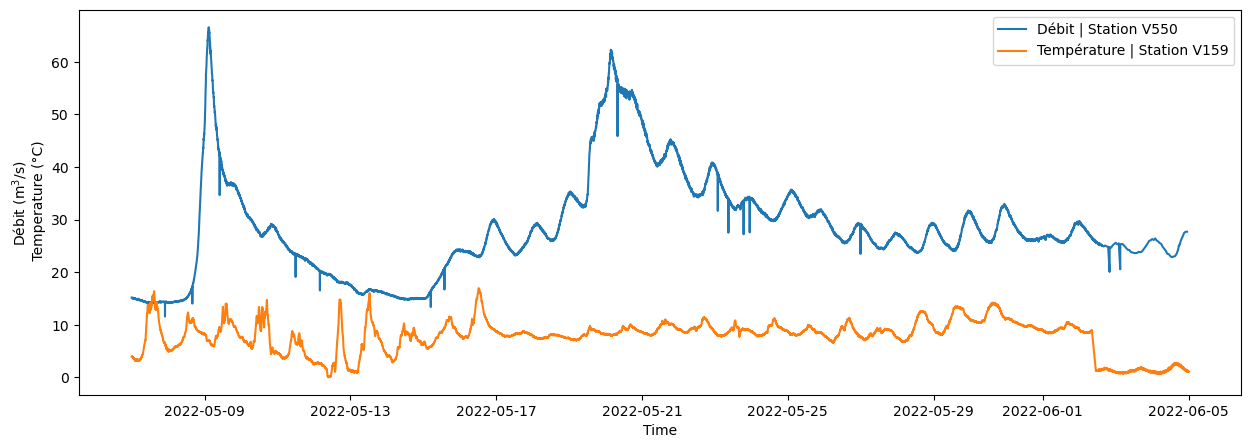

In [129]:
fig = plt.figure(figsize=(15, 5))

plt.plot(gauging_time, gauging_velos, label = 'Débit | Station V550')
plt.plot(temp_time, temp, label = 'Température | Station V159')
plt.xlabel('Time')
plt.ylabel('Débit (m$^3$/s) \n Temperature (°C)')


plt.legend()

#plt.plot(noise_time[1:2000],median[1:2000])
#plt.show()

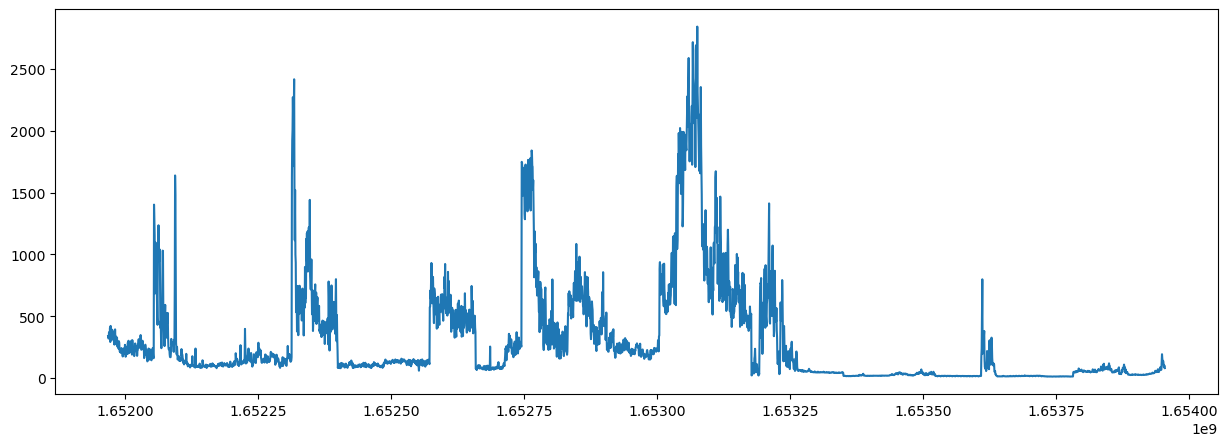

In [134]:
fig = plt.figure(figsize=(15,5))
plt.plot(noise_time,median)
#plt.plot(noise_time,mean)
plt.show()

In [ ]:
fig = plt.subplots(2, 1, figsize=(15, 10))
plt.subplot(2, 1, 1)


plt.plot(gauging_time, gauging_velos, label = 'Débit | Station V550')
plt.plot(temp_time, temp, label = 'Température | Station V159')
plt.xlabel('Time')
plt.ylabel('Débit (m$^3$/s) \n Temperature (°C)')
plt.legend()


plt.subplot(2, 1, 2)

plt.plot(noise_time,median)
plt.plot(noise_time,mean)
plt.xlabel('Time')
plt.ylabel('Median or mean signal amplitude')
plt.show()

In [4]:
root = "D:\\Nodes_ablation_zone\All_comp_DP_\\"
p = obspy.read(root+'453020781.3.2022.05.08.00.00.00.000.Z.miniseed')
print(p)
p.decimate(10)
print(p)
p.decimate(10)

1 Trace(s) in Stream:
SS.20781..DPZ | 2022-05-08T00:00:00.000000Z - 2022-05-09T00:00:00.000000Z | 250.0 Hz, 21600001 samples
1 Trace(s) in Stream:
SS.20781..DPZ | 2022-05-08T00:00:00.000000Z - 2022-05-09T00:00:00.000000Z | 25.0 Hz, 2160001 samples


1 Trace(s) in Stream:
SS.20781..DPZ | 2022-05-08T00:00:00.000000Z - 2022-05-09T00:00:00.000000Z | 2.5 Hz, 216001 samples

In [3]:
p.spectrogram(log=True, title='SS_2O781')

MemoryError: Unable to allocate 352. MiB for an array with shape (1440000, 16) and data type complex128